In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score
import pickle

In [22]:
df = pd.read_csv("../Datas/data.csv")

In [3]:
df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


## Train Test Split

In [4]:
# Split des données avant (train) et après(test) Septembre 2012

In [23]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

## Pipelines

In [24]:
one_hot_features = ["weather", "holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [25]:
rfr = make_pipeline(processor, RandomForestRegressor(random_state=1))
                      
lgbm = make_pipeline(processor, LGBMRegressor(random_state=1))

## Scoring des modèle

In [ ]:
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("Train score :",rfr.score(X_train, y_train))
print("Test score :",rfr.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, y_pred))

Train score : 0.9939255713546519
Test score : 0.9315536191197518
Score R2 : 0.9315536191197518


In [26]:
lgbm.fit(X_train, y_train)
yl_pred = lgbm.predict(X_test)
print("Train score :",lgbm.score(X_train, y_train))
print("Test score :",lgbm.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, yl_pred))

Train score : 0.9706068097473477
Test score : 0.9304244435387465
Score R2 : 0.9304244435387465


In [ ]:
# Trés bons scores pour les deux modèles et sans hyperparamètre avec un peu plus d'overfitting pour RandomForest

In [ ]:
from sklearn.model_selection import learning_curve

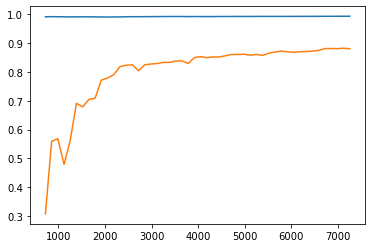

In [ ]:
train_size, train_score, val_score = learning_curve(rfr, X_train, y_train, train_sizes=np.linspace(0.1,1,50), scoring="r2")

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

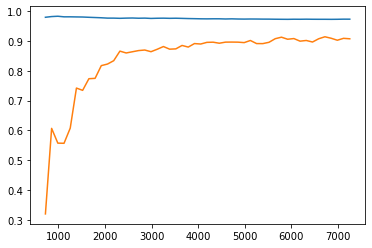

In [ ]:
train_size, train_score, val_score = learning_curve(lgbm, X_train, y_train, train_sizes=np.linspace(0.1,1,50), scoring="r2")

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

## Test de toutes les métriques

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

In [ ]:
def metrics(y_test, y_pred):
    print("r2 :", r2_score(y_test,y_pred))
    print("MAE :", mean_absolute_error(np.exp(y_test),np.exp(y_pred)))
    print("MSE :", mean_squared_error(np.exp(y_test),np.exp(y_pred)))
    print("MeAE :", median_absolute_error(np.exp(y_test),np.exp(y_pred)))

In [ ]:
print("         RFR :")
metrics(y_test=y_test, y_pred=y_pred)

         RFR :
r2 : 0.9315536191197518
MAE : 50.76202840739552
MSE : 6485.460901724803
MeAE : 27.141713867350063


In [ ]:
print("         LGBM :")
metrics(y_test=y_test, y_pred=yl_pred)

         LGBM :
r2 : 0.948016894587881
MAE : 43.976077195121846
MSE : 5229.002819851781
MeAE : 22.53345571492821


Text(0.5, 1.0, 'Prédiction avec le modèle RandomForestRegressor')

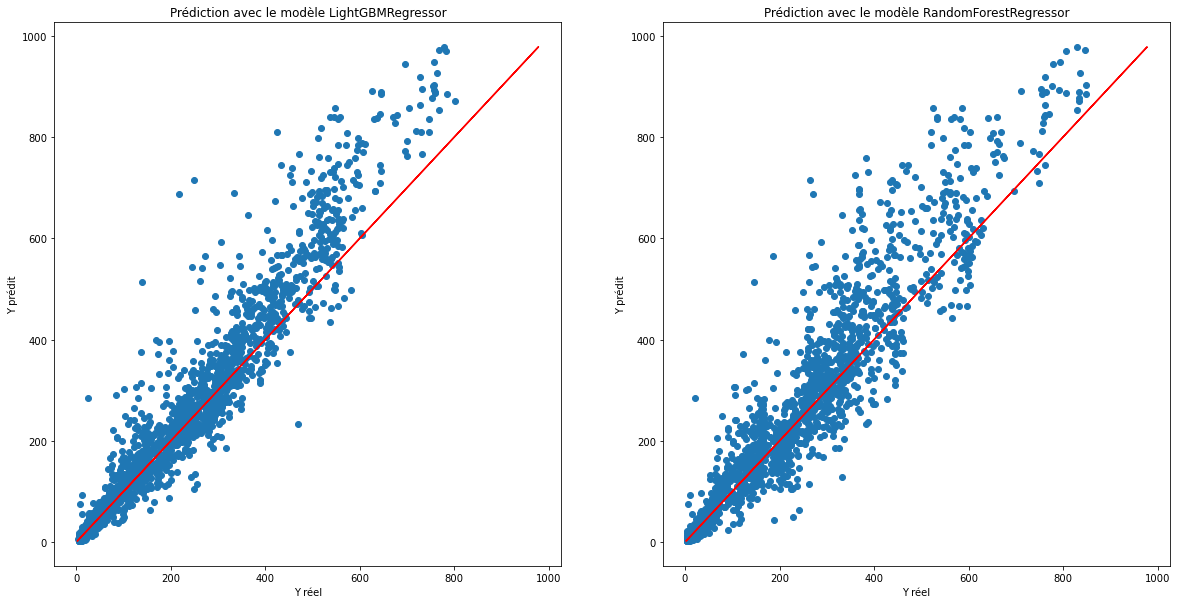

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].scatter(np.exp(yl_pred), np.exp(y_test))
ax[0].plot(np.exp(y_test), np.exp(y_test), c="r")
ax[0].set_xlabel("Y réel")
ax[0].set_ylabel("Y prédit")
ax[0].set_title("Prédiction avec le modèle LightGBMRegressor")
ax[1].scatter(np.exp(y_pred), np.exp(y_test))
ax[1].plot(np.exp(y_test), np.exp(y_test), c="r")
ax[1].set_xlabel("Y réel")
ax[1].set_ylabel("Y prédit")
ax[1].set_title("Prédiction avec le modèle RandomForestRegressor")

## Test de toutes les métriques

In [ ]:
# Le modèle LightGBM a tendance à surévaluer le nombre d'utilisateurs de 45 en moyenne par heure.

In [ ]:
print(max(np.exp(yl_pred)-np.exp(y_test)))

236.06612844582838


## Prédictions

In [ ]:
def make_prediction(y, model):
    pred = np.array(y)
    data_pred = pd.DataFrame(pred, columns=list(X_train.columns))
    for col in list(data_pred.columns):
        try:
            data_pred[col] = data_pred[col].astype(float)
        except:
            pass
    return np.exp(model.predict(data_pred))

In [ ]:
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]], model=rfr))
                
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]],model=lgbm))

[269.12233544 294.03133136 268.66024518]
[338.14838561 211.94094152 338.14838561]


## Comparaison des données avec de grands écarts

In [ ]:
df_pred = X_test
df_pred["y_reel"] = np.exp(np.array(y_test))
df_pred["y_pred"] = np.exp(yl_pred)
df_pred["Ecart"] = df_pred["y_reel"]- df_pred["y_pred"]

In [ ]:
df_pred[abs(df_pred["Ecart"]) > 200].describe()

,season,holiday,workingday,weather,temp,humidity,windspeed,month,day_number,year,hour,y_reel,y_pred,Ecart
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000,56.000000,56.000000
mean,3.803571,0.035714,0.839286,1.892857,21.466429,70.410714,12.625432,10.250000,655.196429,2012.0,12.982143,676.821429,424.839891,251.981537
std,0.400892,0.187256,0.370591,0.778777,4.804610,17.291907,8.317612,0.958218,29.483074,0.0,4.908216,181.669941,175.161140,89.644017
min,3.000000,0.000000,0.000000,1.000000,12.300000,28.000000,0.000000,9.000000,610.000000,2012.0,0.000000,234.000000,24.715554,-236.066128
25%,4.000000,0.000000,1.000000,1.000000,17.835000,57.750000,7.001500,10.000000,640.000000,2012.0,8.000000,560.750000,270.384534,211.350080
50%,4.000000,0.000000,1.000000,2.000000,21.320000,75.000000,11.001400,10.000000,649.000000,2012.0,14.500000,722.500000,464.568792,244.822531
75%,4.000000,0.000000,1.000000,2.250000,25.420000,84.000000,17.498725,11.000000,671.500000,2012.0,17.000000,812.000000,548.466014,286.632244
max,4.000000,1.000000,1.000000,3.000000,31.160000,94.000000,36.997400,12.000000,716.000000,2012.0,21.000000,971.000000,768.209625,471.007702


<AxesSubplot:>

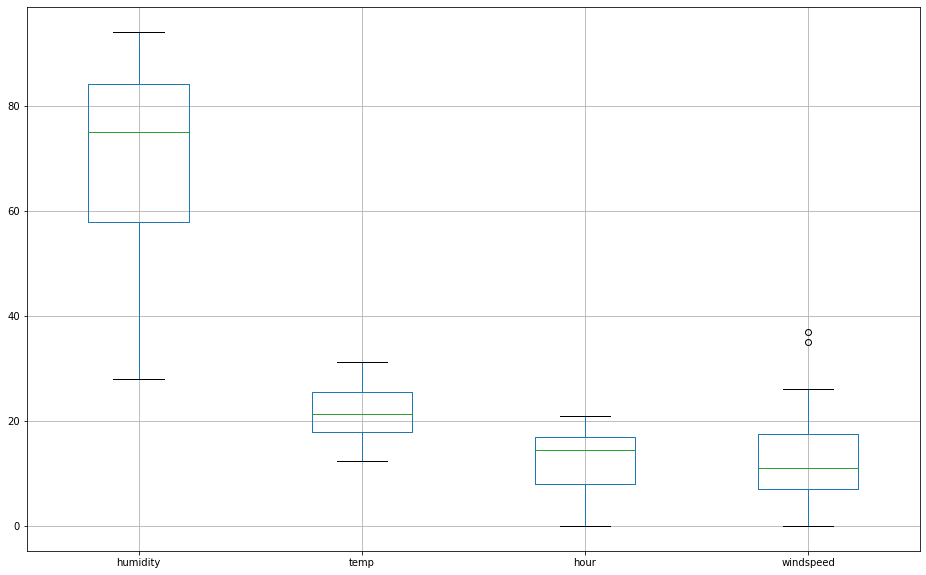

In [ ]:
df_pred[abs(df_pred["Ecart"]) > 200][["humidity", "temp", "hour", "windspeed"]].boxplot(figsize=(16,10))

In [ ]:
# Les valeurs d'humidité sont élevées en moyenne (70.4 %) pour de grands écarts de prédiction.

## Optimisation LightGBMRegressor

In [ ]:
lgbm2 = make_pipeline(processor, LGBMRegressor(random_state=1))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
lgbm_params =  {"lgbmregressor__reg_lambda": [0.01,0.025,0.05,0.075,0.1],
                "lgbmregressor__reg_alpha": [0.2,0.4,0.5,0.6,0.7],
                "lgbmregressor__class_weight": [None,"balanced"],
                "lgbmregressor__colsample_bytree": [0.5,0.7,0.9,1.0]}
grid_lgbm = GridSearchCV(lgbm2, lgbm_params, cv=5, scoring="r2")
grid_lgbm.fit(X_train, y_train)
best_model = grid_lgbm.best_estimator_
print(grid_lgbm.best_params_)
print("Train score :",best_model.score(X_train, y_train))
print("Test score :",best_model.score(X_test, y_test))

{'lgbmregressor__class_weight': None, 'lgbmregressor__colsample_bytree': 1.0, 'lgbmregressor__reg_alpha': 0.4, 'lgbmregressor__reg_lambda': 0.01}
Train score : 0.9698396547454684
Test score : 0.94006295198109


Train score : 0.9698396547454684
Test score : 0.94006295198109


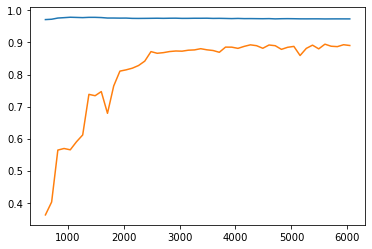

In [ ]:
train_size, train_score, val_score = learning_curve(best_model, X_train, y_train, train_sizes=np.linspace(0.1,1,50), cv=3, scoring="r2")

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

print("Train score :", best_model.score(X_train, y_train))
print("Test score :", best_model.score(X_test, y_test))

Les paramètres de base sont les meilleurs en terme de R²

## Création d'un fichier pickle

In [12]:
filename = "modele.sav"
pickle.dump(lgbm, open(filename,'wb'))

In [21]:
df_test = pd.read_csv("../Datas/data_test.csv")
model = pickle.load(open("modele.sav","rb"))
np.exp(model.predict(df_test))-1

array([  6.46877531,   3.42619827,   1.88639897, ..., 157.28553   ,
       102.85983336,  69.49038347])